In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [113]:
transaction_data = pd.read_csv("CAO_data.csv", parse_dates = ["DATE"])

In [114]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21239 entries, 0 to 21238
Data columns (total 9 columns):
DATE                 21239 non-null datetime64[ns]
CLIENT_ID            21239 non-null int64
CLIENT_SIZE          21239 non-null object
INDUSTRY             21239 non-null object
STATE                21239 non-null object
PRODUCT              21239 non-null object
NUM_LICENSE          21239 non-null int64
PRICE_PER_LICENSE    21239 non-null float64
CSat                 20158 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 1.5+ MB


In [115]:
transaction_data.describe()

,CLIENT_ID,NUM_LICENSE,PRICE_PER_LICENSE,CSat
count,"21,239.0","21,239.0","21,239.0","20,158.0"
mean,"5,495,316.5",6.9,746.3,6.4
std,"2,581,186.7",6.3,229.2,2.0
min,"1,000,810.0",1.0,142.0,1.0
25%,"3,246,700.0",3.0,576.0,5.0
50%,"5,464,179.0",5.0,787.2,7.0
75%,"7,744,617.0",9.0,960.0,8.0
max,"9,999,417.0",58.0,"1,000.0",10.0


# Dealing with missing data

In [116]:
#I used the median value to fill the NA places in CSat column, because median is cannot be affected by outliers
transaction_data['CSat'].fillna(transaction_data['CSat'].median(), inplace=True)

# Create new features

In [117]:
transaction_data["REVENUE"] = transaction_data["NUM_LICENSE"]* transaction_data["PRICE_PER_LICENSE"]
transaction_data["YEAR"] =  pd.DatetimeIndex(transaction_data["DATE"]).year
transaction_data["CLIENT_SIZE"] = transaction_data["CLIENT_SIZE"].astype("category", categories=[u'0-19', u'20-99', u'100-499', u'500+'], ordered=True)


In [165]:
purchase_ranges = transaction_data.groupby("CLIENT_ID")["DATE"].agg([min, max, len])
transaction_data["CLIENT_FIRST_PURCHASE"] = transaction_data.apply(lambda x:purchase_ranges.loc[x["CLIENT_ID"],"min"]==x["DATE"], axis=1)

In [166]:
renewal_flag = transaction_data.groupby("CLIENT_ID").\
apply(lambda x: x.apply(lambda y:(x["DATE"]==(y["DATE"].replace(year=y["DATE"].year-1, day=y["DATE"].day-1) if (y["DATE"].month==2 and y["DATE"].day==29) else y["DATE"].replace(year=y["DATE"].year-1))).sum(), axis=1).astype(bool))
renewal_flag.index = renewal_flag.index.droplevel(0)
transaction_data["RENEWAL"] = renewal_flag.reindex(transaction_data.index)

In [167]:
licenses_per_state = transaction_data.groupby(["PRODUCT", "STATE"]).apply(lambda x:x.sort_values("DATE")["NUM_LICENSE"].cumsum())
licenses_per_state.index = licenses_per_state.index.droplevel([0,1])
transaction_data["licenses_sold_per_state"] = licenses_per_state.reindex(transaction_data.index)

In [168]:
licenses_per_industry = transaction_data.groupby(["PRODUCT", "INDUSTRY"]).apply(lambda x:x.sort_values("DATE")["NUM_LICENSE"].cumsum())
licenses_per_industry.index = licenses_per_industry.index.droplevel([0,1])
transaction_data["licenses_sold_per_industry"] = licenses_per_industry.reindex(transaction_data.index)


In [169]:
sales_per_state_and_year = transaction_data.groupby(["PRODUCT", "STATE", "YEAR"])["NUM_LICENSE", "REVENUE", "CSat"].agg({"NUM_LICENSE":sum, "REVENUE":sum, "CSat":"mean"}).sort_index()
sales_per_state_and_year["ave_price_point"] = sales_per_state_and_year["REVENUE"] / sales_per_state_and_year["NUM_LICENSE"]

sales_per_industry_and_year = transaction_data.groupby(["PRODUCT", "INDUSTRY", "YEAR"])["NUM_LICENSE", "REVENUE", "CSat"].agg({"NUM_LICENSE":sum, "REVENUE":sum, "CSat":"mean"}).sort_index()
sales_per_industry_and_year["ave_price_point"] = sales_per_industry_and_year["REVENUE"] / sales_per_industry_and_year["NUM_LICENSE"]


In [170]:
satisfaction_change = sales_per_industry_and_year.reset_index().set_index("YEAR").groupby(["PRODUCT", "INDUSTRY"])[["CSat"]].apply(lambda x:x.sort_index().diff()).rename(columns={"CSat":"CSat_abs_change"})
sales_change = sales_per_industry_and_year.reset_index().set_index("YEAR").groupby(["PRODUCT", "INDUSTRY"])[["REVENUE", "NUM_LICENSE"]].apply(lambda x:x.sort_index().pct_change()).rename(columns={"REVENUE":"REVENUE_rel_change", "NUM_LICENSE":"NUM_LICENSE_rel_change"})
sales_per_industry_and_year = pd.concat([sales_per_industry_and_year, satisfaction_change, sales_change], axis=1)
sales_per_industry_and_year["CSat_previous"] = sales_per_industry_and_year["CSat"].shift()

In [171]:
client_product_past_relationship = transaction_data.groupby(["CLIENT_ID",
                                                             "PRODUCT"])["YEAR"].unique().reset_index()

In [172]:
client_past_relationship = transaction_data.groupby(["CLIENT_ID"])["YEAR"].unique().reset_index()

In [173]:
transaction_data = pd.merge(transaction_data,
                            client_product_past_relationship.rename(columns={"YEAR":"ALL_YEARS_PROD"})
                                                                    , how="left",on=["CLIENT_ID","PRODUCT"])

In [176]:
transaction_data.head()

,DATE,CLIENT_ID,CLIENT_SIZE,INDUSTRY,STATE,PRODUCT,NUM_LICENSE,PRICE_PER_LICENSE,CSat,REVENUE,YEAR,CLIENT_FIRST_PURCHASE,RENEWAL,licenses_sold_per_state,licenses_sold_per_industry,ALL_YEARS_PROD,ALL_YEARS
0,2014-01-02,9761603,500+,IT,NJ,A,26,770.0,6.0,"20,020.0",2014,True,False,26,26,"[2014, 2015]","[2014, 2015]"
1,2014-01-02,4856499,500+,HEALTH CARE,TX,A,15,930.0,7.0,"13,950.0",2014,True,False,15,15,[2014],"[2014, 2017]"
2,2014-01-02,5855785,0-19,IT,MN,A,1,980.0,5.0,980.0,2014,True,False,1,27,[2014],[2014]
3,2014-01-02,4095393,20-99,IT,NJ,B,4,500.0,9.0,"2,000.0",2014,True,False,4,4,"[2014, 2015, 2016]","[2014, 2015, 2016]"
4,2014-01-02,8152678,0-19,IT,PA,D,3,768.0,6.0,"2,304.0",2014,True,False,3,3,"[2014, 2015, 2016, 2017]","[2014, 2015, 2016, 2017]"


In [175]:
transaction_data = pd.merge(transaction_data,
                            client_past_relationship.rename(columns={"YEAR":"ALL_YEARS"})
                                                                    , how="left",on=["CLIENT_ID"])

In [177]:
transaction_data["PREVIOUS_PROD_CUSTOMER"] = transaction_data.apply(lambda x:
                                                            x["YEAR"]-1 in x["ALL_YEARS_PROD"], axis=1)

In [178]:
transaction_data["PREVIOUS_CUSTOMER"] = transaction_data.apply(lambda x:
                                                            x["YEAR"]-1 in x["ALL_YEARS"], axis=1)

In [179]:
#checking correlation matrix
transaction_data.corr(method='pearson', min_periods=1).style.background_gradient(cmap=sns.light_palette("green", as_cmap=True)).highlight_null(null_color='lightyellow')

,CLIENT_ID,NUM_LICENSE,PRICE_PER_LICENSE,CSat,REVENUE,YEAR,CLIENT_FIRST_PURCHASE,RENEWAL,licenses_sold_per_state,licenses_sold_per_industry,PREVIOUS_PROD_CUSTOMER,PREVIOUS_CUSTOMER
CLIENT_ID,1,0.0172303,0.00172861,0.00450429,0.0129624,-0.00229516,0.00492106,-0.00699761,0.00843291,-0.000867346,-0.00721714,-0.00721714
NUM_LICENSE,0.0172303,1,-0.0903189,0.321577,0.910853,0.00580982,-0.0254689,0.0584677,0.0143065,0.0135057,0.0580708,0.0580708
PRICE_PER_LICENSE,0.00172861,-0.0903189,1,-0.0711768,0.218227,-0.25904,0.0703912,0.148662,0.401949,0.451602,0.148355,0.148355
CSat,0.00450429,0.321577,-0.0711768,1,0.294364,0.0385981,-0.020065,0.0375519,-0.00713793,-0.00441946,0.0373617,0.0373617
REVENUE,0.0129624,0.910853,0.218227,0.294364,1,-0.0708579,-0.00625986,0.105445,0.140231,0.15619,0.105009,0.105009
YEAR,-0.00229516,0.00580982,-0.25904,0.0385981,-0.0708579,1,-0.481368,0.302306,0.442775,0.473167,0.303234,0.303234
CLIENT_FIRST_PURCHASE,0.00492106,-0.0254689,0.0703912,-0.020065,-0.00625986,-0.481368,1,-0.604096,-0.275606,-0.28955,-0.60463,-0.60463
RENEWAL,-0.00699761,0.0584677,0.148662,0.0375519,0.105445,0.302306,-0.604096,1,0.299678,0.336667,0.999118,0.999118
licenses_sold_per_state,0.00843291,0.0143065,0.401949,-0.00713793,0.140231,0.442775,-0.275606,0.299678,1,0.624112,0.299645,0.299645
licenses_sold_per_industry,-0.000867346,0.0135057,0.451602,-0.00441946,0.15619,0.473167,-0.28955,0.336667,0.624112,1,0.336719,0.336719


This correlation matrix shows that the most important factor in revenue is number of number of license sold and renewal

In [120]:
#sns.heatmap(transaction_data.corr())

# Revenue Analysis

In [121]:
suammry_data = pd.pivot_table(transaction_data,index="YEAR", columns="PRODUCT", 
                              values=["REVENUE", "PRICE_PER_LICENSE","NUM_LICENSE","CLIENT_ID",'CSat','STATE','CLIENT_SIZE'],
                              aggfunc={"REVENUE": np.sum, "PRICE_PER_LICENSE" :  np.mean, "NUM_LICENSE": np.sum,
                                       "CLIENT_ID": len, "CSat": np.mean,'STATE':np.sum,'CLIENT_SIZE':len})



In [122]:
suammry_data["REVENUE"]

PRODUCT,A,B,C,D,E
YEAR,,,,,
2014,"10,257,228.0","1,434,632.0","723,168.0","5,083,144.0",nan
2015,"14,962,020.0","2,321,082.0","1,613,052.0","8,103,099.2",nan
2016,"15,706,218.0","2,915,678.0","2,634,639.6","9,762,222.4","32,259.6"
2017,"14,235,042.0","3,301,752.0","4,020,631.2","8,811,371.2","1,390,624.8"


In general total revenue in 2017 is 2.28% higher than 2016

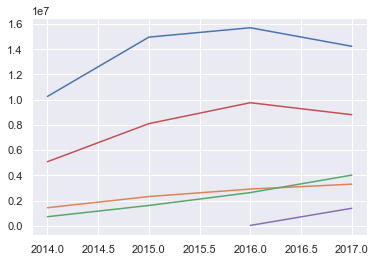

In [123]:
plt.plot(suammry_data["REVENUE"]);

In [124]:
#calculate revenue growth from previous years
pd.options.display.float_format = '%{:,.0f}'.format
suammry_data["REVENUE"].pct_change()*100

PRODUCT,A,B,C,D,E
YEAR,,,,,
2014,%nan,%nan,%nan,%nan,%nan
2015,%46,%62,%123,%59,%nan
2016,%5,%26,%63,%20,%nan
2017,%-9,%13,%53,%-10,"%4,211"


#### The result shows that product C has the highest revenew growth (+53%) over the past 4 years

BUT WHY IT HAPPENED ONLY FOR PRODUCT C? WHAT ARE THE MAIN FACTORS?

In [125]:
pd.options.display.float_format = '{:,.1f}'.format

# Price Per Unit Analysis

In [126]:
suammry_data["PRICE_PER_LICENSE"]

PRODUCT,A,B,C,D,E
YEAR,,,,,
2014,958.4,480.5,573.7,766.6,nan
2015,957.1,479.6,576.1,766.0,nan
2016,957.0,479.7,574.2,767.5,191.3
2017,956.3,479.4,575.4,766.7,192.0


#  Product units sold (Number of License Sold)

In [127]:
suammry_data["NUM_LICENSE"]

PRODUCT,A,B,C,D,E
YEAR,,,,,
2014,"11,064.0","3,066.0","1,305.0","6,829.0",nan
2015,"16,140.0","4,971.0","2,880.0","10,940.0",nan
2016,"16,940.0","6,266.0","4,742.0","13,094.0",174.0
2017,"15,393.0","7,111.0","7,221.0","11,873.0","7,505.0"


So the main reason is that they got more license Sold for all of the products. Now the question is whether they sold more number of licneses to more clients or similiar numbe rof clients, but some of them expand their business?

In [128]:
#number of clustomers over 4 years
suammry_data["CLIENT_ID"]

PRODUCT,A,B,C,D,E
YEAR,,,,,
2014,"1,702.0",498.0,157.0,930.0,nan
2015,"2,340.0",771.0,373.0,"1,496.0",nan
2016,"2,449.0",960.0,598.0,"1,871.0",31.0
2017,"2,193.0","1,071.0",903.0,"1,622.0","1,274.0"


Oh Nice, they expanded their number of clients

In [207]:
client_analysis = pd.pivot_table(transaction_data, index= "CLIENT_ID", columns=["PRODUCT","YEAR"], values=["NUM_LICENSE"], aggfunc={"NUM_LICENSE" : np.sum}).fillna(0)

# Product Analysis

In [181]:
product_name = "C"

In [182]:
losing_contracts = {}
new_contracts = {}
for product in ["A","B","C","D","E"]:
    years= [2014, 2015,2016,2017]
    try:
        this_product = client_analysis["NUM_LICENSE"][product]
        if product =="E":
            years = [2016,2017] 
        this_product["TOTAL_NUMBER_OF_LICENSE_SALES"] = this_product[years].sum(axis=1)
        this_product = this_product.sort_values(by=["TOTAL_NUMBER_OF_LICENSE_SALES"], ascending= False)
        this_product = this_product[this_product["TOTAL_NUMBER_OF_LICENSE_SALES"]>0]
        client_annual_order_change = this_product.diff(axis=1)[years[1:]]
        number_of_losing_contract = client_annual_order_change.agg(lambda x :  x[x<0].sum())
        number_of_new_contract = client_annual_order_change.agg(lambda x :  x[x>0].sum())
        losing_contracts[product] = number_of_losing_contract
        new_contracts[product] = number_of_new_contract
    except:
        pass

# Calcualte Client Annual Order Change

In [184]:
pd.options.display.float_format = '{:,.0f}'.format
pd.DataFrame(new_contracts).fillna(0)

""


In [185]:
pd.options.display.float_format = '{:,.0f}'.format
pd.DataFrame(losing_contracts).fillna(0)

""


As we can see, for prodcut C, the number of new cleint orders that increased year over year, is more than the number of exisiting clients which decided not to work with us, or decrease their number of subscriptions. For other products, this is not usually the case. For Product B, the number of new client order coming in, is bascially the same year over year, but the number of exisitng liceses from exisitng clients is decreasing faster, which shows that the demand more or less exists in the same way but they were not doing a good gob in keeping their customers happy. lets check the customer satisfaction for different products:

In [186]:
pd.options.display.float_format = '{:,.2f}'.format
pd.pivot_table(transaction_data, index = ["YEAR"], columns=["PRODUCT"], values= ["CSat"])

CSat                    
PRODUCT    A    B    C    D    E
YEAR                            
2014    6.12 6.18 6.47 6.52  nan
2015    6.23 6.35 6.47 6.66  nan
2016    6.25 6.41 6.48 6.56 6.61
2017    6.32 6.40 6.55 6.64 6.66

Surpringly overall, the satisfaction score is pretty much the same. Ma be they are switchning to our C product?

# Checking the Major Source of the revenue for each product:

In [187]:
pd.options.display.float_format = '${:,.0f}'.format
suammry_data["REVENUE"].fillna(0)

PRODUCT,A,B,C,D,E
YEAR,,,,,
2014,"$10,257,228","$1,434,632","$723,168","$5,083,144",$0
2015,"$14,962,020","$2,321,082","$1,613,052","$8,103,099",$0
2016,"$15,706,218","$2,915,678","$2,634,640","$9,762,222","$32,260"
2017,"$14,235,042","$3,301,752","$4,020,631","$8,811,371","$1,390,625"


In [188]:
column_to_analyze = "REVENUE"#,"NUM_LICENSE"

Lets anaylze what is the percentage of each revenue, whether it is coming from custoemr we were working with last year, or from new customers

## Previous customers of the product

In [189]:
previous_customers_revenue_data = pd.pivot_table(transaction_data[transaction_data["PREVIOUS_PROD_CUSTOMER"]],
               index="YEAR", values=["REVENUE","NUM_LICENSE"], columns = ["PRODUCT"],
              aggfunc =np.sum).fillna(0)

In [190]:
previous_customers_revenue_data[column_to_analyze]

PRODUCT,A,B,C,D,E
YEAR,,,,,
2015,"$6,699,320","$886,703","$481,938","$3,229,987",$0
2016,"$9,424,906","$1,483,836","$999,569","$5,008,712",$0
2017,"$9,917,500","$1,882,247","$1,735,296","$6,329,522","$19,970"


In [191]:
previous_customers_revenue_data = pd.pivot_table(transaction_data[transaction_data["RENEWAL"]],
               index="YEAR", values=["REVENUE","NUM_LICENSE"], columns = ["PRODUCT"],
              aggfunc =np.sum).fillna(0)

In [192]:
previous_customers_revenue_data[column_to_analyze]

PRODUCT,A,B,C,D,E
YEAR,,,,,
2015,"$6,699,320","$886,703","$481,938","$3,229,987",$0
2016,"$9,424,906","$1,483,836","$999,569","$5,008,712",$0
2017,"$9,910,620","$1,875,084","$1,733,532","$6,320,214","$19,970"


In [193]:
pd.options.display.float_format = '%{:,.0f}'.format
(previous_customers_revenue_data[column_to_analyze]/suammry_data[column_to_analyze].fillna(1)).fillna(0)*100

PRODUCT,A,B,C,D,E
YEAR,,,,,
2014,%0,%0,%0,%0,%0
2015,%45,%38,%30,%40,%0
2016,%60,%51,%38,%51,%0
2017,%70,%57,%43,%72,%1


## New customers of the product

In [194]:
new_customers_revenue_data = pd.pivot_table(transaction_data[~transaction_data["RENEWAL"]],
               index="YEAR", values=["REVENUE","NUM_LICENSE"], columns = ["PRODUCT"],
              aggfunc =np.sum).fillna(0)

In [195]:
new_customers_revenue_pct = (new_customers_revenue_data[column_to_analyze]/suammry_data[column_to_analyze].fillna(1))*100

In [196]:
pd.options.display.float_format = '%{:,.0f}'.format
new_customers_revenue_pct

PRODUCT,A,B,C,D,E
YEAR,,,,,
2014,%100,%100,%100,%100,%0
2015,%55,%62,%70,%60,%0
2016,%40,%49,%62,%49,%100
2017,%30,%43,%57,%28,%99


In [197]:
xx = pd.melt(new_customers_revenue_pct.reset_index(),
                   id_vars=["YEAR"], 
                    value_name = "NEW_CLINETS_PCT_REVENUE").set_index("YEAR")

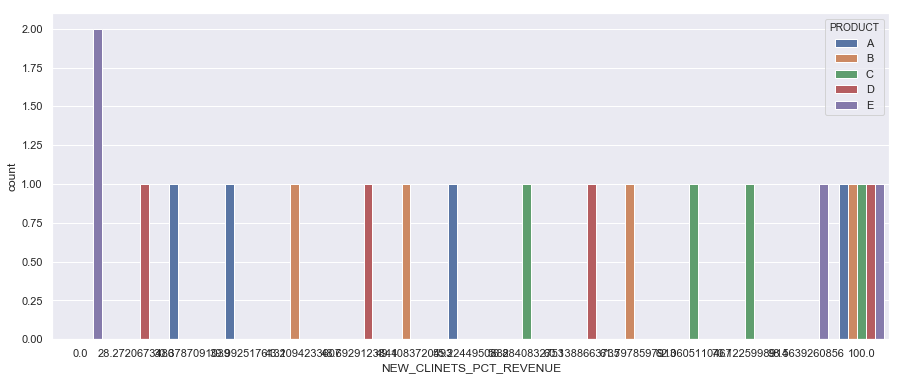

In [198]:

plt.rcParams["figure.figsize"] = (15, 6)
sns.countplot(x=("NEW_CLINETS_PCT_REVENUE"),hue="PRODUCT", 
              data= xx)

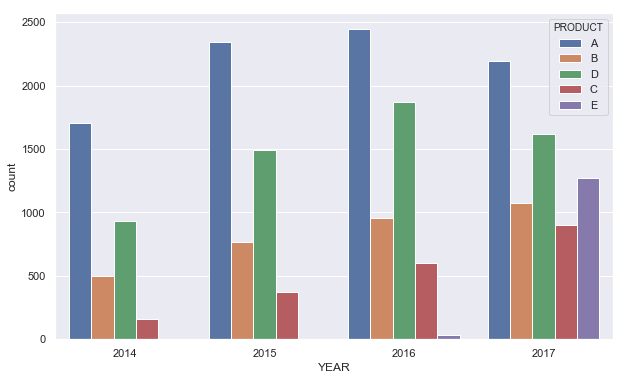

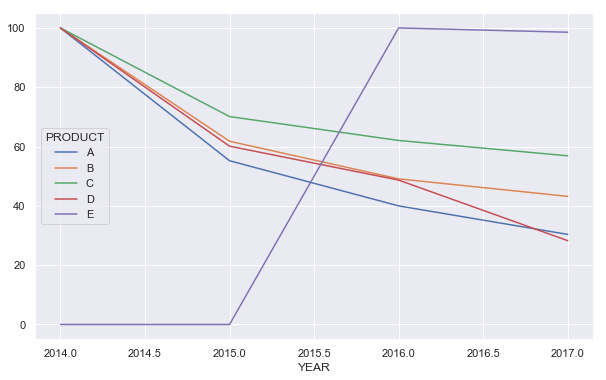

In [199]:
plt.rcParams["figure.figsize"] = (10, 6)
sns.countplot(x=("YEAR"), hue="PRODUCT", data=transaction_data.reset_index());

((new_customers_revenue_data[column_to_analyze]/
  suammry_data[column_to_analyze].fillna(1))*100).plot()

As we can see, year to year, prodcut C and E revenue mostly focus on the new customers, as opposed to teh other products for which the revenue is coming mostly from exisiting customers. that suggests, may be we have done something new that new customers are more interested in C product, or it can be beacuase the price of C and E are in general cheaper than the price of A and D and they are comaprable to B

In [200]:
transaction_data[transaction_data["PREVIOUS_PROD_CUSTOMER"]!=transaction_data["PREVIOUS_CUSTOMER"]]

,DATE,CLIENT_ID,CLIENT_SIZE,INDUSTRY,STATE,PRODUCT,NUM_LICENSE,PRICE_PER_LICENSE,CSat,REVENUE,YEAR,CLIENT_FIRST_PURCHASE,RENEWAL,licenses_sold_per_state,licenses_sold_per_industry,ALL_YEARS_PROD,ALL_YEARS,PREVIOUS_PROD_CUSTOMER,PREVIOUS_CUSTOMER


# Interesting Fact: They change the price based on the number of contracts

one more interesting finding, for all products they are giving some discount to clients of larger size since they usually get more licenses comapred to the smaller size companies, like the more you buy the better discount you get

In [217]:
price_analysis_dollars = transaction_data.groupby(["PRODUCT","CLIENT_SIZE",'YEAR'])["PRICE_PER_LICENSE"].agg(np.mean).reset_index()

In [218]:
pd.pivot_table(price_analysis_dollars, index=["YEAR"], columns= "PRODUCT")

PRICE_PER_LICENSE                    
PRODUCT                 A    B    C    D    E
YEAR                                         
2014                 $941 $471 $562 $753 $nan
2015                 $941 $472 $566 $751 $nan
2016                 $941 $471 $563 $754 $186
2017                 $941 $471 $564 $753 $187

In [219]:
price_analysis = transaction_data.groupby(["PRODUCT","CLIENT_SIZE"])["PRICE_PER_LICENSE"].agg(np.mean).reset_index()
pd.options.display.float_format = '${:,.0f}'.format
pd.pivot_table(price_analysis, index=["CLIENT_SIZE"], columns= "PRODUCT").ix[["0-19","20-99",
                                                                              "100-499","500+"]]

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning:


.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



PRICE_PER_LICENSE                    
PRODUCT                     A    B    C    D    E
CLIENT_SIZE                                      
0-19                     $984 $492 $590 $788 $197
20-99                    $961 $480 $576 $768 $192
100-499                  $938 $470 $565 $751 $187
500+                     $881 $444 $524 $705 $173

# Number of Licenses Analysis

In [209]:
df = pd.melt(client_analysis["NUM_LICENSE"][client_analysis["NUM_LICENSE"]>0].reset_index(),
             id_vars=["CLIENT_ID"], 
            value_name = "NUM_LICENSE").dropna()
df = pd.pivot_table(transaction_data, index=["CLIENT_ID", "PRODUCT"], columns=["YEAR"],
              values = "NUM_LICENSE").fillna(0).reset_index().set_index("CLIENT_ID")
df["TOTAL_NUM_LICENSE"] = df.sum(axis=1)
df = df.reset_index().sort_values(["TOTAL_NUM_LICENSE","CLIENT_ID"],ascending=False)

As you can see in the floowing two tables, the number of licenses for the people who had

In [211]:
df[(df[2017]<20)].set_index("CLIENT_ID").groupby("PRODUCT")\
.apply(lambda x : x[2017]/(x[[2014,2015,2016,2017]].mean(axis=1))).reset_index().\
groupby(["PRODUCT"]).agg(np.mean)


,CLIENT_ID,0
PRODUCT,,
A,"$5,534,719",$1
B,"$5,493,854",$1
C,"$5,514,875",$2
D,"$5,503,871",$1
E,"$5,512,452",$4


In [212]:
df[(df[2017]>20)].set_index("CLIENT_ID").groupby("PRODUCT")\
.apply(lambda x : x[2017]/(x[[2014,2015,2016,2017]].mean(axis=1))).reset_index().\
groupby(["PRODUCT"]).agg(np.mean)

,CLIENT_ID,0
PRODUCT,,
A,"$5,342,553",$2
B,"$5,746,529",$3
C,"$5,570,820",$3
D,"$5,556,265",$2
E,"$6,403,513",$4


# Client segmentation analysis

## Segmentation by industry

In [129]:

#transaction_data['INDUSTRY'].value_counts

In [130]:
Industry_summary = pd.pivot_table(transaction_data,index="YEAR", columns="PRODUCT", 
                              values=["REVENUE", "PRICE_PER_LICENSE","NUM_LICENSE","CLIENT_ID",'CSat','INDUSTRY','STATE'],
                              aggfunc={"REVENUE": np.sum, "PRICE_PER_LICENSE" :  np.mean, "NUM_LICENSE": np.sum,
                                       "CLIENT_ID": len, "CSat": np.mean,'INDUSTRY':len,'STATE':len})


In [131]:
#number of clients per industry per product
transaction_data.groupby(['PRODUCT'])['INDUSTRY'].value_counts().unstack().T

PRODUCT,A,B,C,D,E
INDUSTRY,,,,,
FINANCE,2328,805,506,1531,274
HEALTH CARE,1181,378,242,754,161
IT,3022,1243,766,2069,512
REAL ESTATE,1002,470,253,799,169
RETAIL,1151,404,264,766,189


IT and finance are the major markets for our products (all types)

In [132]:
transaction_data.groupby(['PRODUCT','YEAR'])['INDUSTRY'].value_counts().unstack().T
#the same as number of client per industry just segmented by different year

PRODUCT        A                   B                   C                   D  \
YEAR        2014 2015 2016 2017 2014 2015 2016 2017 2014 2015 2016 2017 2014   
INDUSTRY                                                                       
FINANCE      402  622  647  657  107  178  248  272   40   93  146  227  225   
HEALTH CARE  232  297  331  321   59  104  100  115   16   42   82  102  118   
IT           643  858  868  653  191  288  359  405   65  142  220  339  339   
REAL ESTATE  196  253  284  269   65  108  147  150   19   45   75  114  123   
RETAIL       229  310  319  293   76   93  106  129   17   51   75  121  125   

PRODUCT                       E       
YEAR        2015 2016 2017 2016 2017  
INDUSTRY                              
FINANCE      398  479  429    4  270  
HEALTH CARE  192  240  204    6  155  
IT           521  663  546   11  501  
REAL ESTATE  200  251  225    5  164  
RETAIL       185  238  218    5  184

percentage of new clients added to different industries for product:
A: decreased for all except FINANCE
B: decreased for all (except RETAIL ) 
C: increased for all industries 
D: decreased for all industries 
E: increased sharply over two years


Nice! product C is very popular among RETAIL and REAL ESTATE

# by number of licence sold to clients per industry 

In [133]:
transaction_data.groupby(['PRODUCT','YEAR','INDUSTRY'])['NUM_LICENSE'].sum().unstack().T

PRODUCT         A                       B                      C              \
YEAR         2014  2015  2016  2017  2014  2015  2016  2017 2014  2015  2016   
INDUSTRY                                                                       
FINANCE      2604  4176  4392  4487   643  1132  1629  1761  336   746  1199   
HEALTH CARE  1505  2065  2268  2139   414   678   668   729  155   274   697   
IT           4111  6014  5982  4776  1144  1799  2196  2652  467  1122  1674   
REAL ESTATE  1329  1801  2006  1842   421   741  1070  1066  158   364   609   
RETAIL       1515  2084  2292  2149   444   621   703   903  189   374   563   

PRODUCT               D                      E        
YEAR         2017  2014  2015  2016  2017 2016  2017  
INDUSTRY                                              
FINANCE      1979  1641  2744  3239  3032   16  1360  
HEALTH CARE  1005  1037  1553  1651  1463   52  1016  
IT           2479  2211  3796  4736  4292   68  3033  
REAL ESTATE   873   991  1449  1834  1597   23  1053  
RETAIL        885   949  1398  1634  1489   15  1043

Number of licence sold to different industries for product:
A: decreased for all except FINANCE 
B: increased for all 
C: increased for all industries (MAX FINANCE 60%, RETAIL 57%)sharp
D: decreased for all industries (Max HEALTH CARE 11% and REAL STATE 12%)
E: increased sharply over two years


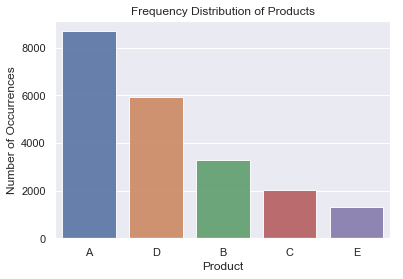

In [134]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
product_count = transaction_data['PRODUCT'].value_counts()
sns.set(style="darkgrid")
sns.barplot(product_count.index, product_count.values, alpha=0.9)
plt.title('Frequency Distribution of Products')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.show();

In [135]:
(transaction_data.groupby(['PRODUCT'])['INDUSTRY'].value_counts().unstack().T)

PRODUCT,A,B,C,D,E
INDUSTRY,,,,,
FINANCE,2328,805,506,1531,274
HEALTH CARE,1181,378,242,754,161
IT,3022,1243,766,2069,512
REAL ESTATE,1002,470,253,799,169
RETAIL,1151,404,264,766,189


# satisfaction over years

In [136]:
transaction_data.groupby(['PRODUCT','YEAR'])['CSat'].mean().unstack().T

PRODUCT,A,B,C,D,E
YEAR,,,,,
2014,6.1,6.2,6.5,6.5,nan
2015,6.2,6.4,6.5,6.7,nan
2016,6.3,6.4,6.5,6.6,6.6
2017,6.3,6.4,6.6,6.6,6.7


this shows satisfaction has important role in revenue and sale of each product, CSat for C is the only one it is increased over 4 years

In [137]:
transaction_data.groupby(['PRODUCT','INDUSTRY'])['CSat'].mean().unstack().T

PRODUCT,A,B,C,D,E
INDUSTRY,,,,,
FINANCE,7.2,7.5,7.6,7.6,7.5
HEALTH CARE,5.9,6.0,6.2,6.4,6.7
IT,5.9,5.9,6.1,6.2,6.4
REAL ESTATE,5.9,6.1,6.2,6.3,6.5
RETAIL,5.8,6.1,6.2,6.2,6.3


SHOWS ALL THE PRODUCTS ARE VERY SATISFACTORY AMONG FINANCE INDUSTRY--- 

In [138]:
transaction_data.groupby(['PRODUCT','YEAR'])['CSat'].mean().unstack().T

PRODUCT,A,B,C,D,E
YEAR,,,,,
2014,6.1,6.2,6.5,6.5,nan
2015,6.2,6.4,6.5,6.7,nan
2016,6.3,6.4,6.5,6.6,6.6
2017,6.3,6.4,6.6,6.6,6.7


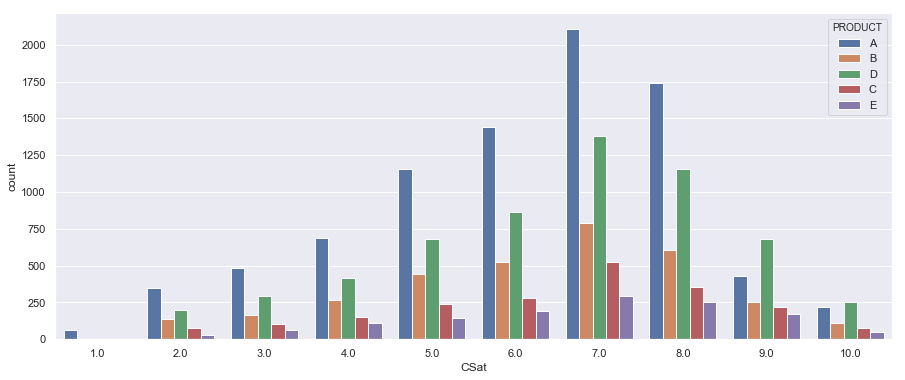

In [139]:
plt.rcParams['figure.figsize'] = (15, 6)
sns.countplot(x=('CSat'), hue='PRODUCT', data=transaction_data);

# Segmentation by customer company size

In [140]:
transaction_data['CLIENT_SIZE'].value_counts()

0-19       9326
20-99      5356
100-499    4341
500+       2216
Name: CLIENT_SIZE, dtype: int64

This shows in general, most of our customers are small size companies (0-19)

In [141]:
#number of customers by company size for different products
transaction_data.groupby(['YEAR','CLIENT_SIZE'])['PRODUCT'].count().unstack()

CLIENT_SIZE,0-19,100-499,20-99,500+
YEAR,,,,
2014,1542,653,760,332
2015,2143,1033,1276,528
2016,2532,1233,1539,605
2017,3109,1422,1781,751


In [142]:
#number of license sold for each product basedon compant size
transaction_data.groupby(['PRODUCT','CLIENT_SIZE'])['NUM_LICENSE'].sum().unstack()

CLIENT_SIZE,0-19,100-499,20-99,500+
PRODUCT,,,,
A,9305,17059,13436,19737
B,3709,6697,4818,6190
C,2892,4782,3605,4869
D,7238,12555,10286,12657
E,1575,2099,1820,2185


In [143]:
#average number of sale units for different company size
transaction_data.groupby(['PRODUCT','CLIENT_SIZE'])['NUM_LICENSE'].mean().unstack()

CLIENT_SIZE,0-19,100-499,20-99,500+
PRODUCT,,,,
A,2.5,9.5,6.2,20.0
B,2.5,9.5,5.9,19.5
C,3.2,11.3,7.3,24.3
D,2.8,10.6,6.6,21.2
E,2.4,9.4,5.7,19.3


THE MEAN VALUE OF SALE FOR DIFFERENT COMPANY SIZE ARE THE SAME AMOMG ALL PRODUCTS ---SO "VERY LARGE" COMPANIES BUY IN AVERAGE 19 LICENCE AND MAKE THE MOST REVENUE AMONG OTHER COMPANIES WITH DIFFERENT SIZES

In [144]:
#total revenue per product type for different company sizes
transaction_data.groupby(['PRODUCT','CLIENT_SIZE'])['REVENUE'].sum().unstack().T

PRODUCT,A,B,C,D,E
CLIENT_SIZE,,,,,
0-19,"9,160,074.0","1,825,128.0","1,707,369.6","5,701,009.6","309,900.0"
100-499,"15,932,352.0","3,133,821.0","2,697,956.4","9,395,121.6","391,413.6"
20-99,"12,870,198.0","2,303,858.0","2,071,747.2","7,864,577.6","348,217.6"
500+,"17,197,884.0","2,710,337.0","2,514,417.6","8,799,128.0","373,353.2"


In [145]:
transaction_data.groupby(['INDUSTRY','CLIENT_SIZE'])['NUM_LICENSE'].count().unstack().T

INDUSTRY,FINANCE,HEALTH CARE,IT,REAL ESTATE,RETAIL
CLIENT_SIZE,,,,,
0-19,2474,1156,3451,1089,1156
100-499,1103,553,1423,647,615
20-99,1336,716,1893,686,725
500+,531,291,845,271,278


# CHECK CUSTOMER SATISFACTION BY CLIENT SIZE

In [146]:
#customer satisfaction for customers from different company sizes
transaction_data[transaction_data['CLIENT_SIZE']=='500+']['CSat'].mean()

7.79783393501805

In [147]:
transaction_data[transaction_data['CLIENT_SIZE']=='100-499']['CSat'].mean()

7.079474775397374

In [148]:
transaction_data[transaction_data['CLIENT_SIZE']=='20-99']['CSat'].mean()

6.702203136669156

In [149]:
transaction_data[transaction_data['CLIENT_SIZE']=='0-19']['CSat'].mean()

5.598112802916577

this is interesting, it shows the larger the company size is the higher the customer satisfaction

# PLOTS

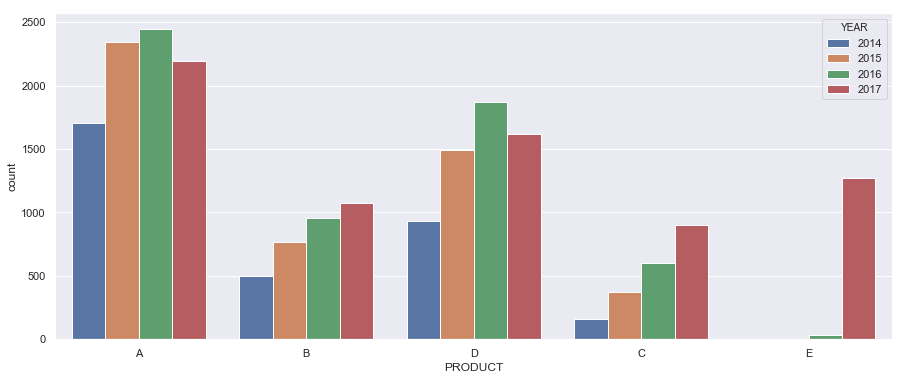

In [150]:
%matplotlib inline
import matplotlib.pyplot as plt 
# pip install seaborn 
import seaborn as sns
plt.rcParams['figure.figsize'] = (15, 6)
sns.countplot(x='PRODUCT', hue='YEAR', data=transaction_data);

This plot shows the number of unit sold per product decreased over 4 years for product A and D ..Also it constantly increased for product C

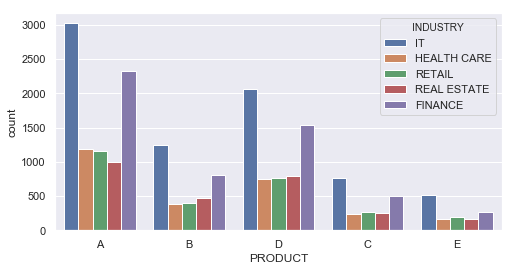

In [151]:
plt.rcParams['figure.figsize'] = (8, 4)
sns.countplot(x='PRODUCT', hue='INDUSTRY', data=transaction_data);

This plot shows the main customers of our client products are from IT and FINANCE

This plot shows customer satisfaction rate does not have significant impact on revenue based on previous analysis

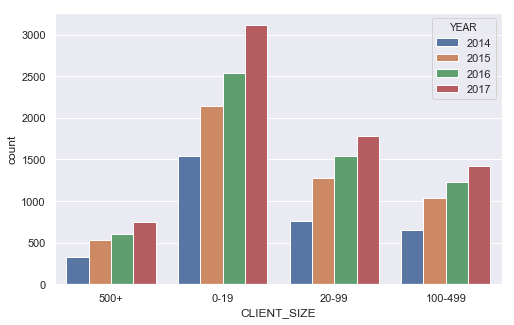

In [152]:
plt.rcParams['figure.figsize'] = (8, 5)
sns.countplot(x=('CLIENT_SIZE'), hue='YEAR', data=transaction_data);

This figure displays that most of our clients are companies with 0-19 employees

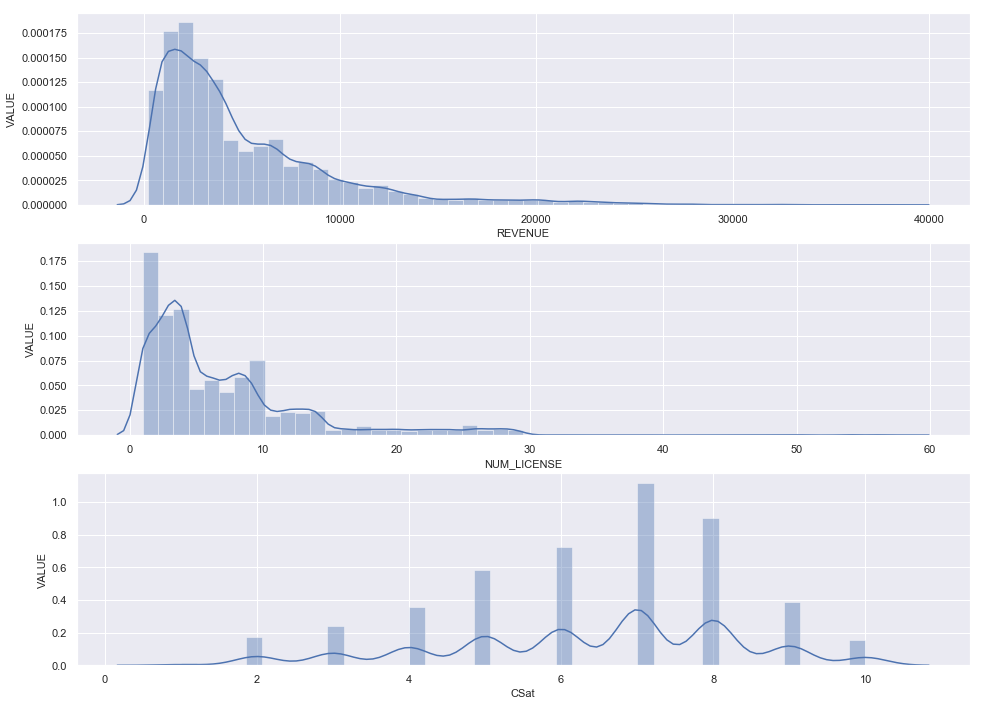

In [156]:
col_names = ['REVENUE','NUM_LICENSE','CSat']

fig, ax = plt.subplots(len(col_names), figsize=(16,12))

for i, col_val in enumerate(col_names):

    sns.distplot(transaction_data[col_val], hist=True, ax=ax[i])
    #ax[i].set_title(col_val, fontsize=10)
    ax[i].set_xlabel(col_val, fontsize=11)
    ax[i].set_ylabel('VALUE', fontsize=11)

plt.show();

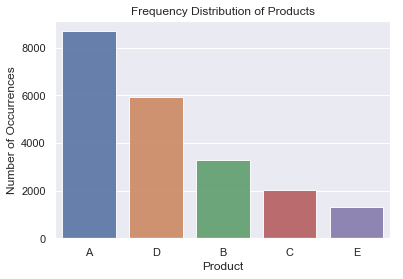

In [157]:
#unit sold per product
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
product_count = transaction_data['PRODUCT'].value_counts()
sns.set(style="darkgrid")
sns.barplot(product_count.index, product_count.values, alpha=0.9)
plt.title('Frequency Distribution of Products')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.show();

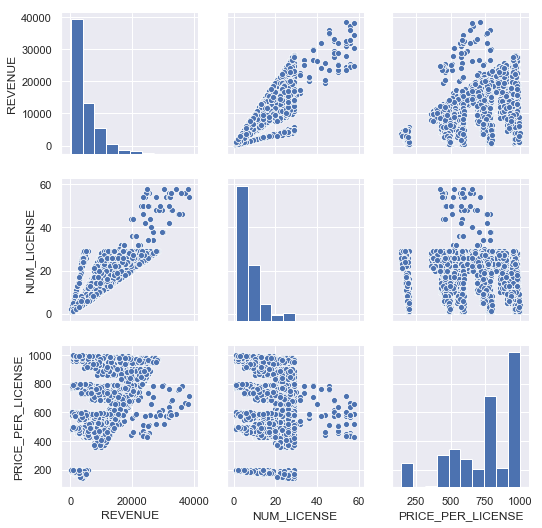

In [158]:
sns.pairplot(transaction_data[['REVENUE','NUM_LICENSE','PRICE_PER_LICENSE']]);

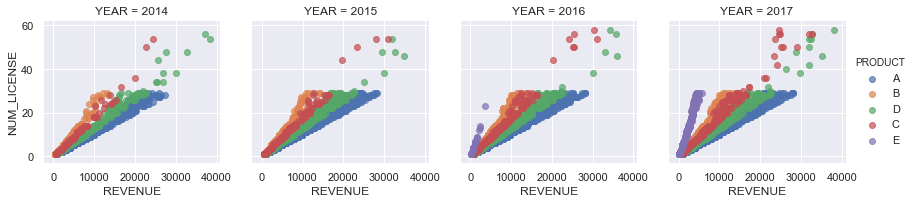

In [159]:
g = sns.FacetGrid(transaction_data, col="YEAR", hue="PRODUCT")
g.map(plt.scatter, 'REVENUE',"NUM_LICENSE", alpha=.7)
g.add_legend();

# Geographic segmentation 

In [160]:
transaction_data.groupby(['STATE','YEAR'])['NUM_LICENSE'].count().unstack().T

STATE,CA,CO,FL,GA,IL,IN,MA,MD,MI,MN,NC,NJ,NY,PA,TX,VA
YEAR,,,,,,,,,,,,,,,,
2014,507,134,102,231,213,114,233,127,115,112,139,235,458,108,334,125
2015,785,171,182,368,319,162,368,194,152,171,173,351,714,177,521,172
2016,873,239,191,426,416,204,428,217,200,189,190,428,805,234,626,243
2017,1031,280,241,495,468,228,530,225,252,242,278,522,972,305,724,270


In [161]:
transaction_data.groupby(['STATE','YEAR'])['REVENUE'].sum().unstack().T

STATE,CA,CO,FL,GA,IL,IN,MA,MD,MI,MN,NC,NJ,NY,PA,TX,VA
YEAR,,,,,,,,,,,,,,,,
2014,"2,603,972.6","653,371.0","567,916.4","1,201,585.2","1,227,835.4","671,298.2","1,270,758.8","663,773.0","663,867.8","526,396.0","809,578.2","1,257,900.6","2,394,007.4","556,260.2","1,763,406.4","666,244.8"
2015,"4,144,578.4","875,555.4","951,720.6","1,957,051.6","1,754,835.4","874,139.2","2,086,038.2","1,042,909.0","906,995.2","938,048.6","1,004,070.0","1,994,102.4","3,664,592.4","945,245.4","2,891,927.8","967,443.6"
2016,"4,683,707.6","1,171,400.4","1,029,859.4","2,265,176.2","2,131,842.8","1,009,564.4","2,381,928.8","1,124,949.0","1,090,158.0","966,650.6","1,058,600.2","2,290,470.2","3,966,029.8","1,227,258.6","3,311,011.0","1,342,410.6"
2017,"4,927,401.0","1,194,044.6","1,086,198.2","2,179,597.4","2,023,103.4","961,969.8","2,363,415.4","1,064,694.2","1,153,632.4","1,121,350.2","1,330,205.2","2,283,503.4","4,094,248.0","1,327,784.2","3,336,310.0","1,311,963.8"


In [162]:
import plotly.plotly as py

In [163]:

# Python program to plot  
# geographical data using plotly 
  
# importing all necessary libraries 
import plotly.plotly as py 
import plotly.graph_objs as go 
import pandas as pd 
  
# some more libraries to plot graph 
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot 
  
# To establish connection 
init_notebook_mode(connected = True) 
  
  
# type defined is choropleth to 
# plot geographical plots 
data = dict(type = 'choropleth', 
  
            # location: Arizoana, California, Newyork 
            locations = ['CA','CO','FL','GA','IL','IN','MA','MD','MI','MN','NC','NJ','NY','PA','TX','VA'], 
              
            # States of USA 
            locationmode = 'USA-states', 
              
            # colorscale can be added as per requirement 
            colorscale = 'Reds', 
              
            # text can be given anything you like 
            text = ['CA','CO','FL','GA','IL','IN','MA','MD','MI','MN','NC','NJ','NY','PA','TX','VA'], 
            z = [4927401.0,1194044.6,1086198.2,2179597.4,2023103.4,961969.8,2363415.4,1064694.2,1153632.4,1121350.2,1330205.2,2283503.4,4094248.0,1327784.2,3336310.0,1311963.8], 
            colorbar = {'title': 'REVENUE 2017'}) 
              
layout = dict(geo ={'scope': 'usa'}) 
  
# passing data dictionary as a list  
choromap = go.Figure(data = [data], layout = layout) 
  
# plotting graph 
iplot(choromap) 

In [164]:

# Python program to plot  
# geographical data using plotly 
  
# importing all necessary libraries 
import plotly.plotly as py 
import plotly.graph_objs as go 
import pandas as pd 
  
# some more libraries to plot graph 
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot, plot 
  
# To establish connection 
init_notebook_mode(connected = True) 
  
  
# type defined is choropleth to 
# plot geographical plots 
data = dict(type = 'choropleth', 
  
            # location: Arizoana, California, Newyork 
            locations = ['CA','CO','FL','GA','IL','IN','MA','MD','MI','MN','NC','NJ','NY','PA','TX','VA'], 
              
            # States of USA 
            locationmode = 'USA-states', 
              
            # colorscale can be added as per requirement 
            colorscale = 'Blues', 
            reversescale = True,
            # text can be given anything you like 
            text = ['CA','CO','FL','GA','IL','IN','MA','MD','MI','MN','NC','NJ','NY','PA','TX','VA'], 
            z = [2603972.6,653371.0,567916.4,1201585.2,1227835.4,671298.2,1270758.8,663773.0,663867.8,526396.0,809578.2,1257900.6,2394007.4,556260.2,1763406.4,666244.8], 
            colorbar = {'title': 'REVENUE 2014'}) 
            
            
layout = dict(geo ={'scope': 'usa'}) 
  
# passing data dictionary as a list  
choromap = go.Figure(data = [data], layout = layout) 
  
# plotting graph 
iplot(choromap) 